# DSCI 100 Group Project Proposal

team: Rachel Liang, Ziyan He, Yuchen Zhang, Zohane Bal

In [2]:
### Run this cell before continuing. 
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("tests.R")
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Introduction    

The dataset we are working on is downloaded from the UCI Machine Learning Repository. Although the dataset contains four databases about the heart disease diagnosis from 4 different locations, we only picked the database collected from the Cleveland Clinic Foundation since it is the only data base that has full 14 attributes recored for each heart disease diagnosis. The total instances in this database is 303.

### Load Data and Wrangle Data
This dataset does not need to be cleaned since it does not have any missing data or missing attributes. <br>
We added column names to the dataset and selected columns we needed for analysis. Also as we are treating some attributes's numeric values as categorical variables, we used as.factor() for conversion.

In [3]:
set.seed(1234)

heart_disease_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"


heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num"))
heart_disease_data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### 14 Attributes Description
* Age: age in years
* Sex: ( 1 = male, 0 = female)
* Cp: chest pain type
Value 1: typical angina
Value 2: atypical angina
Value 3: non-anginal pain
Value 4 asymptomatic
* Trestbps: Resting Blood pressure ( in mm Hg on admission to hospital)
* Chol: Serum cholesterol in mg/dl
* Fbs: Fastig blood suger > 120 (1 = true, 0 = false)
* Dm: 1 = history if diabetes , 0 = no such history)
* Restecg: Resting electro cardiac results
Value 0 : normal
Value 1: having ST-T wave abnormality ( T wave inversion and/or ST elevation or depression of > 0.05 mV)
Value 2” Showing probable or definite left ventricular hypertrophy by Estes’ criteria
* Thalach: maximum heart rate achieved
* Exang: exercise induced angina (1 = yes ,0 = no)
* Oldpeak:ST depression induced by exercise relative to rest
* Slope: The slope of the peak exercise ST segment
Value 1: upsloping
Value 2: flat
Value 3: downsloping
* Ca: Number of major vessels (0-3) coloured by fluorosopy
* Thal: 3 = normal , 6= fixed defect , 7 = reversible defect
* Num: diagnosis of heart disease
Value 0 <50% diameter narrowing
Value 1 > 50% Diameter narrowing

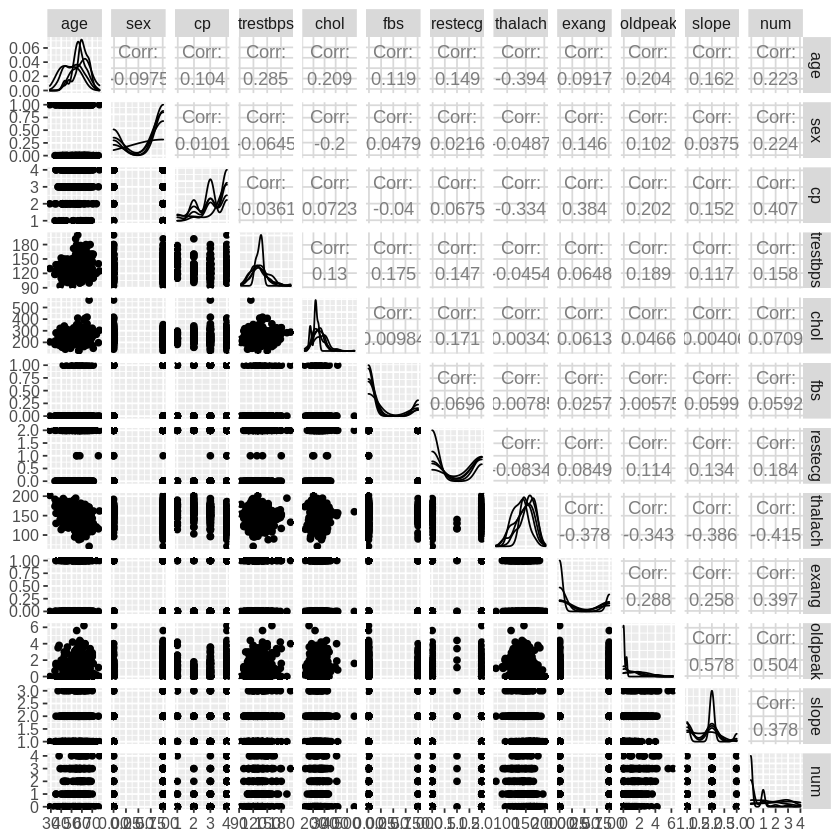

In [4]:
correlation_plot <- heart_disease_data %>% 
                select(-ca, -thal) %>% 
                ggpairs(heart_disease_data[1:12]) +
                theme(text = element_text(size = 12))

correlation_plot

`summarise()` regrouping output by 'num' (override with `.groups` argument)



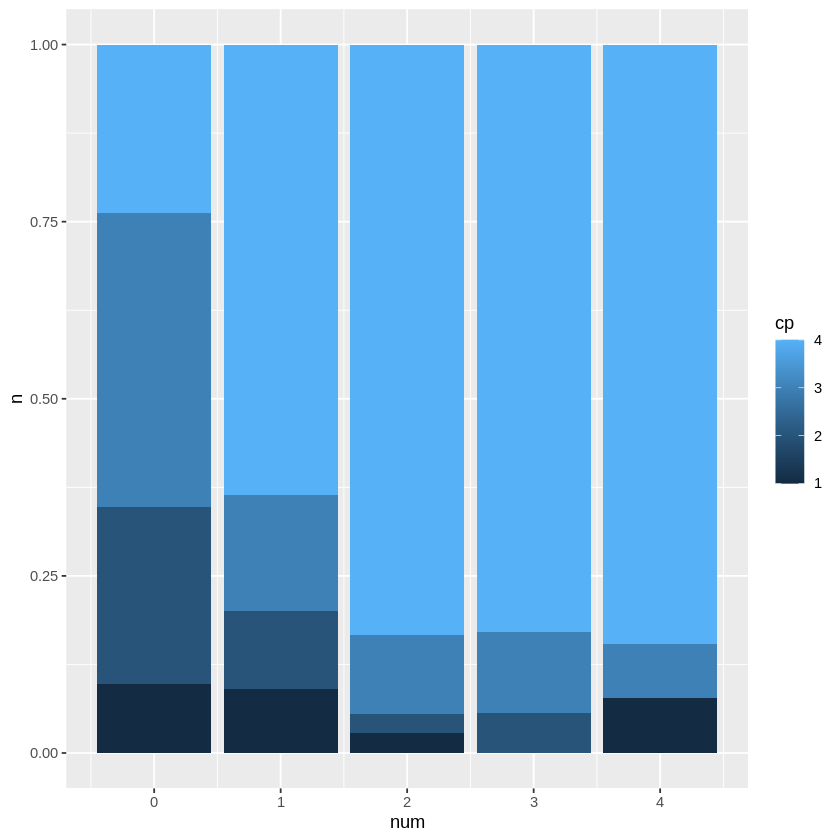

In [5]:
cp_vs_num <- heart_disease_data %>% 
            select(num, cp) %>% 
            group_by(num, cp) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = cp)) +
            geom_bar(stat = "identity",position = "fill")
cp_vs_num

`summarise()` regrouping output by 'num' (override with `.groups` argument)



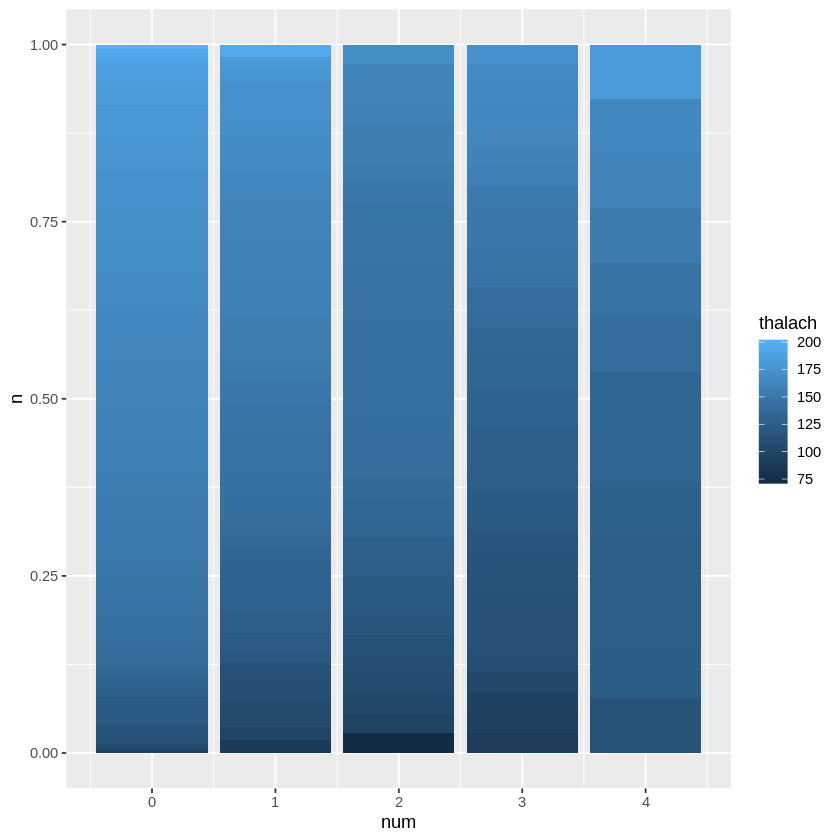

In [6]:
thalach_vs_num <- heart_disease_data %>% 
            select(num, thalach) %>% 
            group_by(num, thalach) %>% 
            summarize(n = n()) %>%
            ggplot(aes(x = num, y = n, fill = thalach)) +
            geom_bar(stat = "identity",position = "fill")
thalach_vs_num

In [7]:
set.seed(1234)
heart_disease_data <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                        mutate(cp = as.factor(cp), fbs = as.factor(fbs), restecg = as.factor(restecg), 
                            exang = as.factor(exang), slope = as.factor(slope), sex = as.factor(sex)) %>% 
                        select(age, sex, cp, thalach, exang, slope, num, oldpeak) 
heart_disease_data

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



age,sex,cp,thalach,exang,slope,num,oldpeak
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
63,1,1,150,0,3,0,2.3
67,1,4,108,1,2,2,1.5
67,1,4,129,1,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,115,1,2,3,1.2
57,0,2,174,0,2,1,0.0
38,1,3,173,0,1,0,0.0


### Check for balancing

In [7]:
num_obs <- nrow(heart_disease_data)
        heart_disease_data %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<dbl>,<int>,<dbl>
0,164,54.125413
1,55,18.151815
2,36,11.881188
3,35,11.551155
4,13,4.290429


drawing multiple histograms and the x-axis is the num (possibility of getting heart disease : 0, 1, 2, 3) and the y-axis is the count. color the bar using position "filled" with each column (such as cp, fbs according to the larger correlation in the ggpair). if this variable has a high correlation related to getting heart disease, the proportion of color will be filled more in the larger x-axis, and otherwise. Also use medical research to add ontop of the correlation because correlation does not mean causation.

In [8]:
set.seed(1234)
heart_disease_data_2 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
#                         mutate(num = as.factor(num)) %>% 
#                         mutate(cp = as.numeric(as.factor(cp)), fbs = as.factor(fbs), restecg = as.factor(restecg), 
#                             exang = as.numeric(as.factor(exang)), slope = as.numeric(as.factor(slope)), 
#                                sex = as.numeric(as.factor(sex))) %>% 
                        select(cp, thalach, exang, slope, oldpeak, num) 
heart_disease_data_2

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,2
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,3
2,174,0,2,0.0,1
3,173,0,1,0.0,0


In [9]:
heart_disease_data_3 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    select(cp, thalach, exang, slope, oldpeak, num) 
heart_disease_data_3                

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


### Check for balancing new

In [10]:
num_obs_new <- nrow(heart_disease_data_3)
        heart_disease_data_3 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_new * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<dbl>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


### Split Into Training and Testing Dataset
Based on the number of instances in this dataset, we decided that setting 75% of the data in the dataset as training data and the remaining 25% as testing data will make a good balance for training the classifier and evaluating the classifier's accuracy.

In [9]:
set.seed(1234)
heart_disease_split <- initial_split(heart_disease_data_2, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

head(heart_disease_data_2, 10)

age,sex,cp,thalach,exang,slope,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,150,0,3,0
67,1,4,108,1,2,2
67,1,4,129,1,2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,163,1,1,0
63,1,4,147,0,2,2
53,1,4,155,1,3,1


### Summary

In [10]:
summary(heart_disease_train)

      age             sex             cp           thalach          exang      
 Min.   :29.00   Min.   :0.00   Min.   :1.000   Min.   : 71.0   Min.   :0.000  
 1st Qu.:48.00   1st Qu.:0.00   1st Qu.:3.000   1st Qu.:132.0   1st Qu.:0.000  
 Median :56.00   Median :1.00   Median :4.000   Median :152.0   Median :0.000  
 Mean   :54.48   Mean   :0.69   Mean   :3.227   Mean   :148.6   Mean   :0.345  
 3rd Qu.:61.00   3rd Qu.:1.00   3rd Qu.:4.000   3rd Qu.:165.0   3rd Qu.:1.000  
 Max.   :77.00   Max.   :1.00   Max.   :4.000   Max.   :202.0   Max.   :1.000  
     slope      num    
 Min.   :1.00   0:123  
 1st Qu.:1.00   1: 43  
 Median :2.00   2: 27  
 Mean   :1.62   3: 27  
 3rd Qu.:2.00   4:  9  
 Max.   :3.00          

### Visualization


The boxplot below shows the distribution of age for each different probability level of having a heart disease.

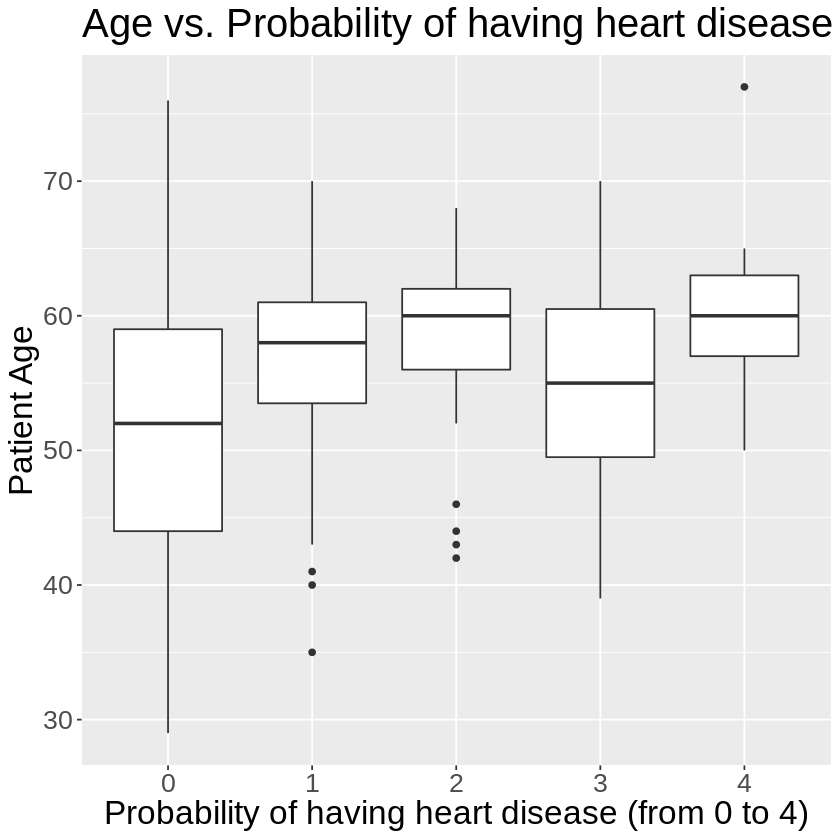

In [11]:
age_vs_heart_disease <- heart_disease_train %>% 
                    ggplot(aes(x = num, y = age)) +
                    geom_boxplot(aes(group = num)) +
                    labs(x = "Probability of having heart disease (from 0 to 4)", y = "Patient Age") +
                    ggtitle("Age vs. Probability of having heart disease (from 0 to 4)") +
                    theme(text = element_text(size = 20))
                    
age_vs_heart_disease

The graph2 below shows the distribution of different chest pain types for different probability levels of having heart disease.<br>
Chest pain type 1-4 means:
* Value 1: typical angina
* Value 2: atypical angina
* Value 3: non-anginal pain
* Value 4: asymptomatic
<br>


`summarise()` regrouping output by 'num' (override with `.groups` argument)



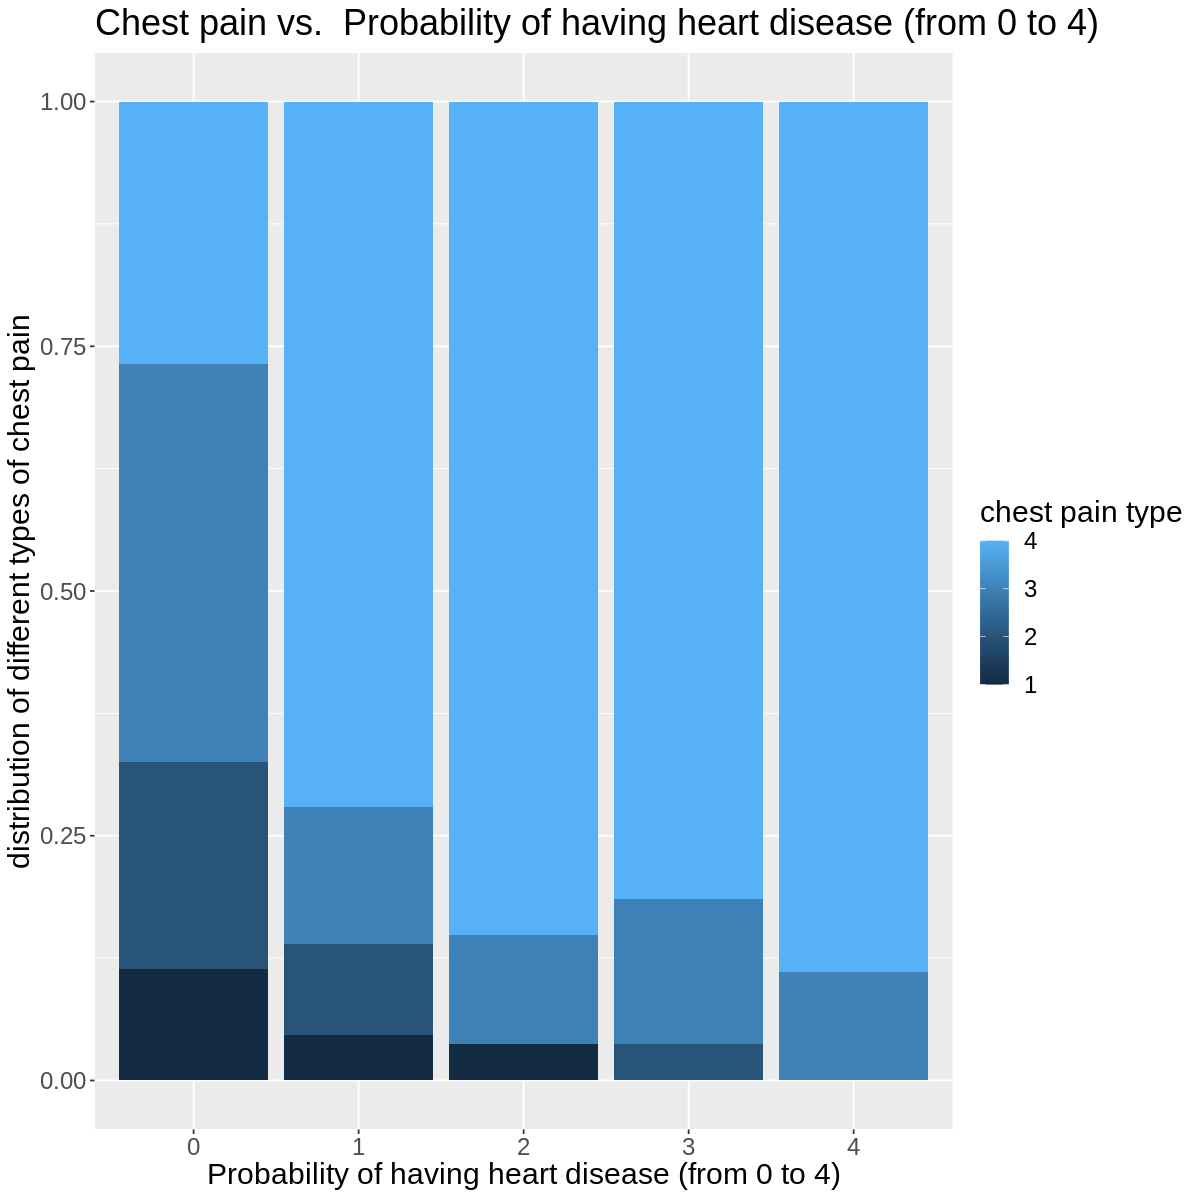

In [12]:
options(repr.plot.width = 10, repr.plot.height = 10) 

sex_vs_heart_disease <- heart_disease_train %>% 
                        select(num, cp) %>% 
                        group_by(num, cp) %>% 
                        summarize(n = n()) %>% 
                        ggplot(aes(x = num, y = n, fill = cp)) +
                        geom_bar(stat = "identity",position = "fill") +
                        labs(x =  "Probability of having heart disease (from 0 to 4)", y = "distribution of different types of chest pain", fill = "chest pain type") +
                        ggtitle("Chest pain vs.  Probability of having heart disease (from 0 to 4)") +
                        theme(text = element_text(size = 18))
sex_vs_heart_disease

### Method

In order to make the prediction, there are three steps to do:
1. Create a k-nn model specification and a recipe for the fit method.
2. Train the model with the training dataset to build the classifier.
3. Use the classifier to predict the labels in the test sets.       

#### 6 Predictors chosen:
* age, sex, chest pain types (cp), thalach, exang, oldpeak, the slope of the peak exercise ST segment(slope)




### Expected Outcomes and Significance    

1. What do you expect to find?   

    Our training dataset will allow us to predict the probability of an individual contracting heart disease given patient's . 
    Additionally, we hope to discover which factors are most associated with a person's risk of developing a heart disease.  

2. What impact could such findings have?    

    With this finding, doctors would be able to analyze patients’ records in a more informative manner. It will be easier to make a swift decision to conduct further diagnostic cardiology on the patient if a certain index is abnormal as indicated in the report later, and this will significantly reduce the chance of misdiagnosis and provide more time for patient diagnosis and treatment.  

3. What future questions could this lead to?   

    As this dataset only has 303 instances which is not sufficient for making accurate predictions, we could increase the accuracy of prediction by including more instances . Furthermore, since this data set only contains patients’ data in Cleveland, it would also be interesting to observe if the key factors leading to heart disease differ between different locations if we have a heart disease data set from a collection of locations. 


### Create models

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


### Create Recipe--MISSING UPSAMPLE

In [14]:
heart_recipe <- recipe(num ~ ., data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

# MISSING STEP_UPSAMPLE
# bake <- bake(heart_recipe,heart_disease_train)



heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)

# FITTING Model

k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit <- workflow() %>% 
            add_recipe(heart_recipe) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)



! Fold1: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4477212,5,0.03865558,Model01
2,accuracy,multiclass,0.4477212,5,0.03865558,Model02
3,accuracy,multiclass,0.5161845,5,0.01699778,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.5856111,5,0.01510565,Model48
49,accuracy,multiclass,0.5769113,5,0.01575812,Model49
50,accuracy,multiclass,0.5726560,5,0.01780151,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
35,accuracy,multiclass,0.6070944,5,0.01752921,Model35


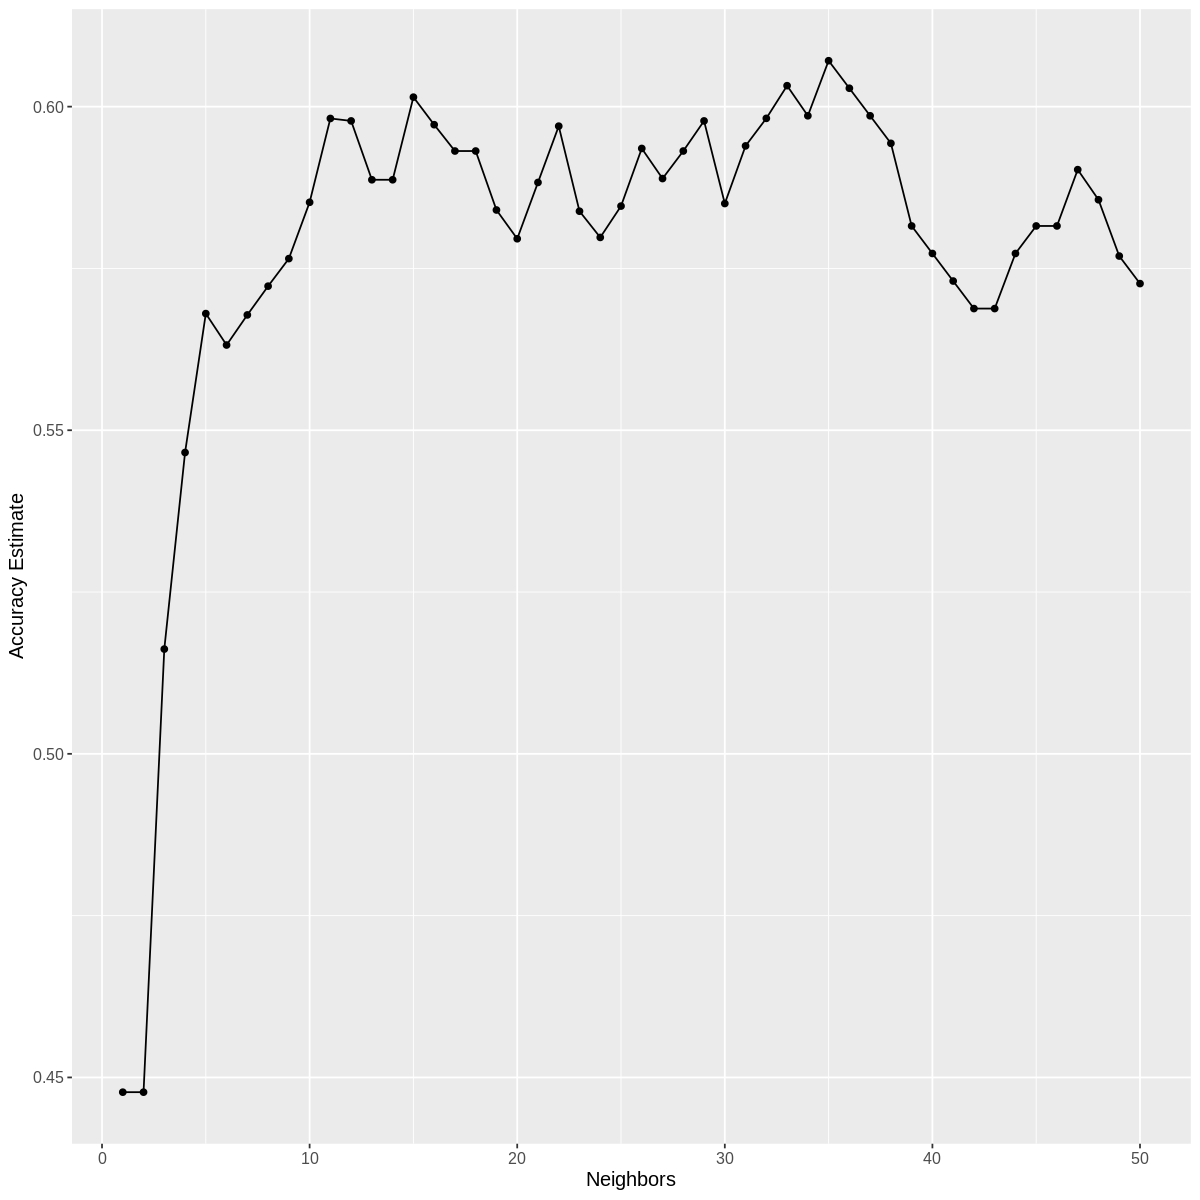

In [15]:
# set metrics

heart_disease_metrics <- knn_fit %>% 
                        collect_metrics()

accuracies <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") 
accuracies
    
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

accuracies_final <- heart_disease_metrics %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final


In [16]:
# knn_tune

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_2 <- workflow() %>% 
  add_recipe(heart_recipe) %>% 
  add_model(knn_spec_2) %>% 
  fit(data = heart_disease_train)



In [17]:
# make predictions

heart_prediction <- predict(knn_fit_2, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics <- heart_prediction %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat <- heart_prediction %>% 
                 conf_mat(truth = num, estimate = .pred_class)

# mnist_metrics <- mnist_predictions %>%
#         metrics(truth = y, estimate = .pred_class) %>% 
#         filter(.metric == "accuracy")
# mnist_metrics
# mnist_conf_mat <- mnist_predictions %>% 
#                 conf_mat(truth = y, estimate = .pred_class)
heart_metrics
mnist_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5675676


          Truth
Prediction  0  1  2  3  4
         0 39  9  3  4  3
         1  1  1  4  2  1
         2  0  0  0  0  0
         3  1  2  2  2  0
         4  0  0  0  0  0

## optimizing our classifier


! Fold5: internal: No observations were detected in `truth` for level(s): '4'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4459572,5,0.01730657,Model01
2,accuracy,multiclass,0.4547579,5,0.02113924,Model02
3,accuracy,multiclass,0.4810595,5,0.02525107,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,multiclass,0.5810125,5,0.01485793,Model48
49,accuracy,multiclass,0.5810125,5,0.01485793,Model49
50,accuracy,multiclass,0.5854570,5,0.01681385,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
44,accuracy,multiclass,0.6033402,5,0.02041724,Model44


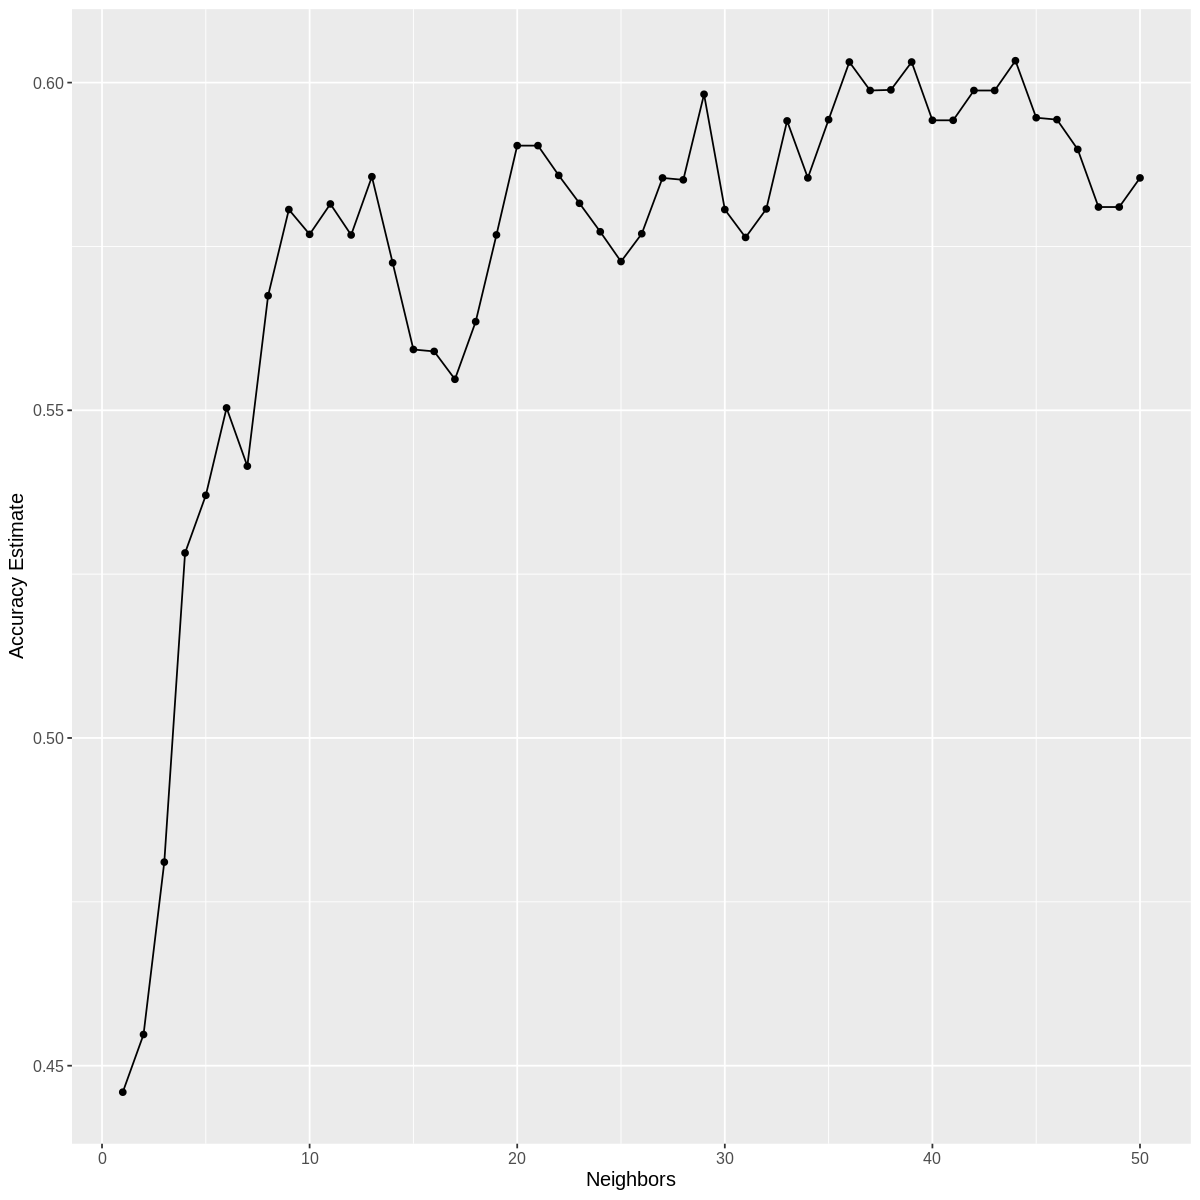

In [18]:
heart_recipe_new <- recipe(num ~ sex + cp + thalach + exang + slope, data = heart_disease_train)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold <- vfold_cv(heart_disease_train, v = 5, strata = num)


# FITTING Model

k_lots <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_new <- workflow() %>% 
            add_recipe(heart_recipe_new) %>% 
            add_model(knn_spec) %>% 
            tune_grid(resamples = heart_disease_vfold, grid = k_lots)



heart_disease_metrics_new <- knn_fit_new %>% 
                        collect_metrics()

accuracies_new <- heart_disease_metrics_new %>% 
        filter(.metric == "accuracy") 
accuracies_new
    
accuracy_vs_k_new <- ggplot(accuracies_new, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_new

accuracies_final_new <- heart_disease_metrics_new %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)

accuracies_final_new




In [19]:
knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

knn_fit_new <- workflow() %>% 
  add_recipe(heart_recipe_new) %>% 
  add_model(knn_spec_2) %>% 
  fit(data = heart_disease_train)

heart_prediction_new <- predict(knn_fit_new, heart_disease_test) %>% 
                    bind_cols(heart_disease_test)

heart_metrics_new <- heart_prediction_new %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_new <- heart_prediction_new %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics_new
mnist_conf_mat_new

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5945946


          Truth
Prediction  0  1  2  3  4
         0 39  9  4  4  2
         1  1  1  2  1  0
         2  1  0  1  0  1
         3  0  2  2  3  1
         4  0  0  0  0  0

### Questions to ask: 
- upsample --> change the predicted variable to binary categorical. 
- final visualization
- optimizing our number of k neighbours
- clean up R error
- is our classifier trained: validate with test data
- 
- do we need to compare our result with the initial hypothesis using graphs
- potential risks -- TODO


using five predictors: with high correlation.
binary categorical -- 0 and 1
final visulizatino with bar chart(quantitative and categorical), boxplot(quantitative): 

## Mutating Num to binary categorical

In [29]:
heart_disease_data_3 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>% 
                    select(cp, thalach, exang, slope, oldpeak, num) 
heart_disease_data_3    

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,115,1,2,1.2,1
2,174,0,2,0.0,1
3,173,0,1,0.0,0


## Check for balancing

In [30]:
num_obs_new <- nrow(heart_disease_data_3)
        heart_disease_data_3 %>% 
        group_by(num) %>% 
        summarize(
        count = n(),
        percentage = n() / num_obs_new * 100)

`summarise()` ungrouping output (override with `.groups` argument)



num,count,percentage
<fct>,<int>,<dbl>
0,164,54.12541
1,139,45.87459


## Spliting and training data

In [31]:
set.seed(1234)
heart_disease_split_mut <- initial_split(heart_disease_data_3, prop = 0.75, strata = num)
heart_disease_train_mut <- training(heart_disease_split_mut)
heart_disease_test_mut <- testing(heart_disease_split_mut)

head(heart_disease_data_3, 10)

cp,thalach,exang,slope,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,3,2.3,0
4,108,1,2,1.5,1
4,129,1,2,2.6,1
⋮,⋮,⋮,⋮,⋮,⋮
4,163,1,1,0.6,0
4,147,0,2,1.4,1
4,155,1,3,3.1,1


## Create model

In [32]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [33]:
heart_recipe_mut <- recipe(num ~ ., data = heart_disease_train_mut)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut <- vfold_cv(heart_disease_train_mut, v = 5, strata = num)


In [34]:
k_lots_mut <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_fit_mut <- workflow() %>% 
            add_recipe(heart_recipe_mut) %>% 
            add_model(knn_spec_mut) %>% 
            tune_grid(resamples = heart_disease_vfold_mut, grid = k_lots_mut) 

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7285024,5,0.02711991,Model01
2,accuracy,binary,0.7285024,5,0.02711991,Model02
3,accuracy,binary,0.7022222,5,0.02322089,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7850242,5,0.004950218,Model48
49,accuracy,binary,0.7850242,5,0.008471342,Model49
50,accuracy,binary,0.7850242,5,0.008471342,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
26,accuracy,binary,0.8026087,5,0.01386701,Model26


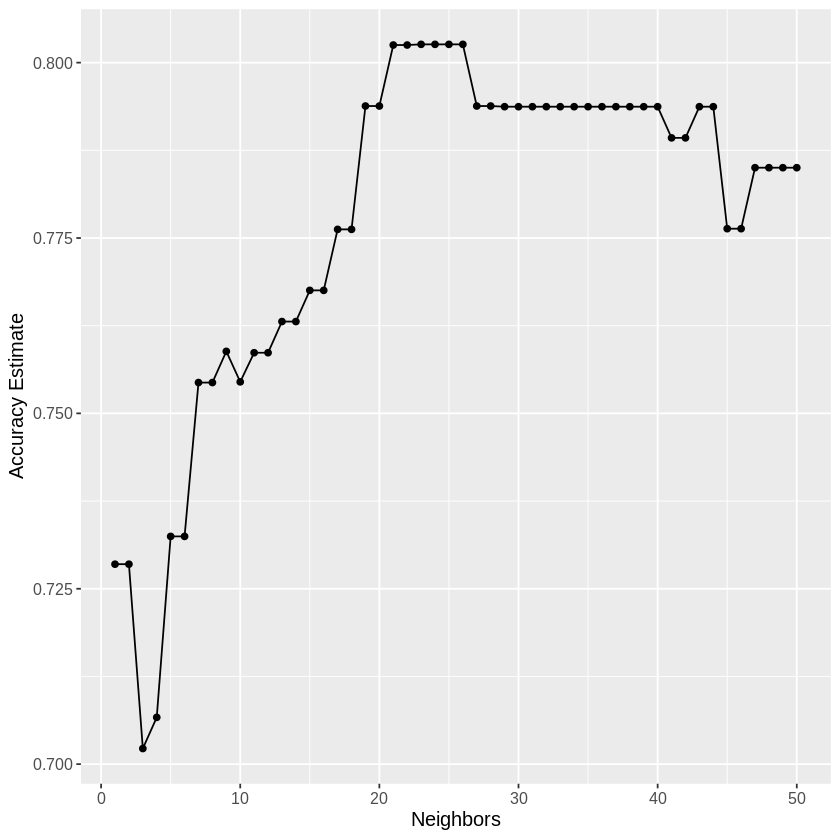

In [35]:
heart_disease_metrics_mut <- knn_fit_mut %>% 
                        collect_metrics()

accuracies_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") 
accuracies_mut
    
accuracy_vs_k_mut <- ggplot(accuracies_mut, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_mut

accuracies_final_mut <- heart_disease_metrics_mut %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut

In [42]:
knn_spec_mut <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec_mut

knn_fit_mut <- workflow() %>% 
  add_recipe(heart_recipe_mut) %>% 
  add_model(knn_spec_mut) %>% 
  fit(data = heart_disease_train_mut)
knn_fit_mut

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 26
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~26, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2324561
Best kernel: rectangular
Best k: 26

In [43]:
heart_prediction_mut <- predict(knn_fit_mut, heart_disease_test_mut) %>% 
                    bind_cols(heart_disease_test_mut)

heart_metrics_mut <- heart_prediction_mut %>% 
                metrics(truth = num, estimate = .pred_class) %>% 
                filter(.metric == "accuracy")

mnist_conf_mat_mut <- heart_prediction_mut %>% 
                 conf_mat(truth = num, estimate = .pred_class)
heart_metrics_mut
mnist_conf_mat_mut

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8133333


          Truth
Prediction  0  1
         0 35  8
         1  6 26

## 4 predictors

In [45]:
heart_disease_data_4 <- read_csv(heart_disease_url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                                               "restecg", "thalach", "exang", "oldpeak", "slope",
                                                               "ca", "thal", "num")) %>% 
                    mutate(num = replace(num, num =='2',1)) %>% 
                    mutate(num = replace(num, num =='3',1)) %>% 
                    mutate(num = replace(num, num =='4',1)) %>% 
                    mutate(num = as.factor(num)) %>% 
                    select(cp, thalach, exang, oldpeak, num) 
heart_disease_data_4   

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



cp,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0
4,108,1,1.5,1
4,129,1,2.6,1
⋮,⋮,⋮,⋮,⋮
4,115,1,1.2,1
2,174,0,0.0,1
3,173,0,0.0,0


In [50]:
set.seed(1234)
heart_disease_split_mut_4 <- initial_split(heart_disease_data_4, prop = 0.75, strata = num)
heart_disease_train_mut_4 <- training(heart_disease_split_mut_4)
heart_disease_test_mut_4 <- testing(heart_disease_split_mut_4)

head(heart_disease_data_4, 10)

cp,thalach,exang,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,150,0,2.3,0
4,108,1,1.5,1
4,129,1,2.6,1
⋮,⋮,⋮,⋮,⋮
4,163,1,0.6,0
4,147,0,1.4,1
4,155,1,3.1,1


In [52]:
knn_spec_mut_4 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn")%>%
            set_mode("classification") 
knn_spec_mut_4

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [55]:
heart_recipe_mut_new_4 <- recipe(num ~ ., data = heart_disease_train_mut_4)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors()) 

heart_disease_vfold_mut_4 <- vfold_cv(heart_disease_train_mut_4, v = 5, strata = num)

In [ ]:
k_lots_mut_4 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_fit_mut_4 <- workflow() %>% 
            add_recipe(heart_recipe_mut_new_4) %>% 
            add_model(knn_spec_mut_4) %>% 
            tune_grid(resamples = heart_disease_vfold_mut_4, grid = k_lots_mut_4)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6584541,5,0.03703648,Model01
2,accuracy,binary,0.6582609,5,0.02875415,Model02
3,accuracy,binary,0.6931401,5,0.01281004,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,accuracy,binary,0.7809662,5,0.01760179,Model48
49,accuracy,binary,0.7809662,5,0.01760179,Model49
50,accuracy,binary,0.7809662,5,0.01760179,Model50


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
50,accuracy,binary,0.7809662,5,0.01760179,Model50


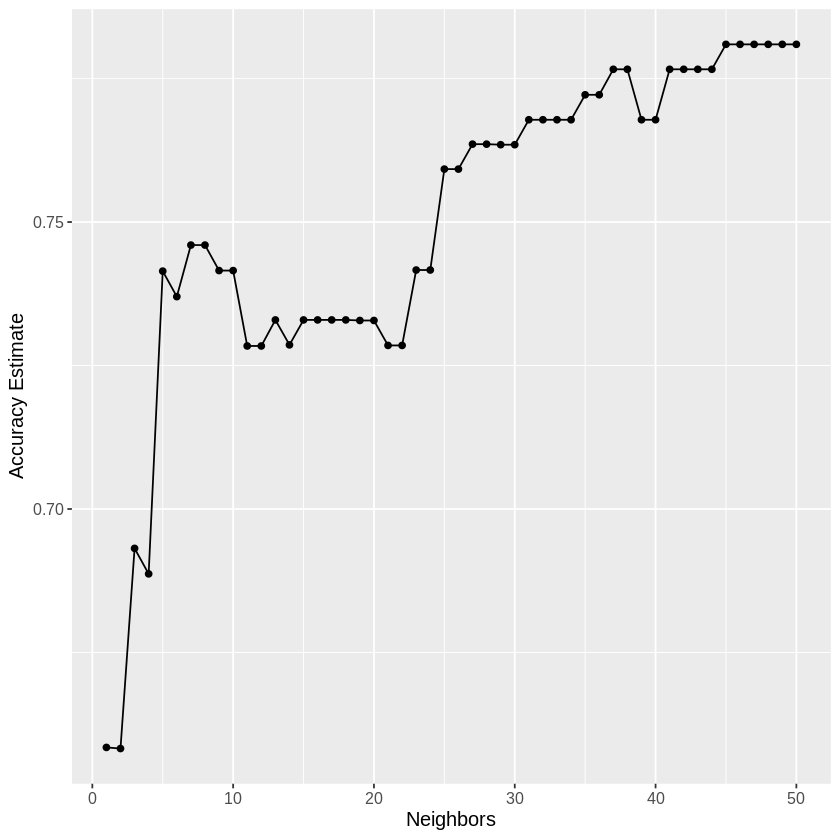

In [57]:
heart_disease_metrics_mut_4 <- knn_fit_mut_4 %>% 
                        collect_metrics()

accuracies_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") 
accuracies_mut_4
    
accuracy_vs_k_mut_4 <- ggplot(accuracies_mut_4, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k_mut_4

accuracies_final_mut_4 <- heart_disease_metrics_mut_4 %>% 
        filter(.metric == "accuracy") %>% 
        arrange(mean) %>% 
        tail(1)
accuracies_final_mut_4

In [ ]:
source("cleanup.R")